In [1]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/LEST/LESTfusion1.csv"

def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/LESTY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")


#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)
"""
# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)

#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#prec words
interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)


#cfl words
df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)

#cfm words
df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)


#temp words
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
df_all["tempd0_l"] = ["0" + c if len(c) == 1 else c for c in round((df_all["temp0"]-273.16)- (100 - df_all["rh0"]*100) / 5,0).astype(int).astype(str)]

#mslp words
pres = round(df_all["mslp0"]/100,0).astype(int).astype(str)
df_all["mslp0_l"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["visibility0_l"]+" "+df_all["prec0_l"]+" "+df_all["cfl0_l"]+" "+df_all["cfm0_l"]+" "+df_all["temp0_l"]+ " "+df_all["tempd0_l"]+" "+df_all["mslp0_l"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
result["fusion"].to_csv(path_result)

result["fusion"].sample(100).values

array(['24013kt 4000 prec0y CL9 CM2 09 08 q1008 23008KT 200V290 9000 FEW022 SCT035 BKN045 10/08 Q1010 NOSIG',
       '22011kt 9999 prec0n CL4 CM0 14 14 q1018 23006KT 160V280 9999 SCT013 BKN025 16/13 Q1019 TEMPO BKN010',
       '36005kt 500 prec0n CL6 CM5 09 09 q1036 01003KT 340V040 1200 R17/1900N R35/P2000 -DZ BR VV001 09/09 Q1035 TEMPO 0700 BCFG',
       '21015kt 9999 prec0n CL5 CM0 17 15 q1019 22010KT 180V280 9999 BKN012 OVC018 18/15 Q1019 NOSIG',
       '25007kt 500 prec0n CL4 CM0 12 12 q1017 VRB02KT 9000 FEW002 SCT009 BKN040 12/12 Q1016 TEMPO 3000 DZ BKN010',
       '28009kt 5000 prec0y CL0 CM1 09 08 q1022 27004KT 240V310 8000 3500E -RA BKN001 BKN008 OVC012 08/08 Q1022 TEMPO 3000 DZ',
       '22017kt 500 prec0y CL0 CM9 11 10 q1005 23016G30KT 200V280 9999 SCT010 BKN014 BKN021 11/11 Q1010 RERA WS ALL RWY NOSIG',
       '14011kt 9999 prec0n CL0 CM0 17 09 q1010 VRB03KT 9999 SCT015 14/11 Q1010 NOSIG',
       '10007kt 9999 prec0n CL0 CM0 17 14 q1017 12004KT 090V160 9999 FEW030 16/13 Q101

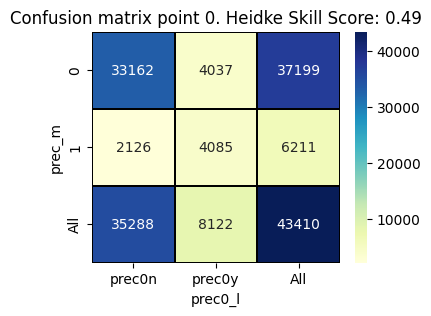

In [2]:
#@title Precipitation
df_prec =pd.concat([df_all[["prec0_l","prec0"]],station_raw['wxcodes_o']],axis=1).dropna()
df_prec["prec_m"] = [1 if "RA" in c or "DZ" in c else 0 for c in df_prec["wxcodes_o"]]
df_prec

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_prec.prec_m, df_prec.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

,visibility0,visibility_o
visibility0,1.000000,0.350504
visibility_o,0.350504,1.000000


,visibility0,visibility_o,visibility0_l
count,43410.000000,43410.000000,43410.000000
mean,20934.215805,8846.994978,8691.769800
std,7574.659389,2457.771545,3154.223063
min,27.293736,48.000000,100.000000
25%,24037.490234,9994.000000,9999.000000
50%,24043.878906,9994.000000,9999.000000
75%,24074.496094,9994.000000,9999.000000
max,24235.000000,9994.000000,9999.000000


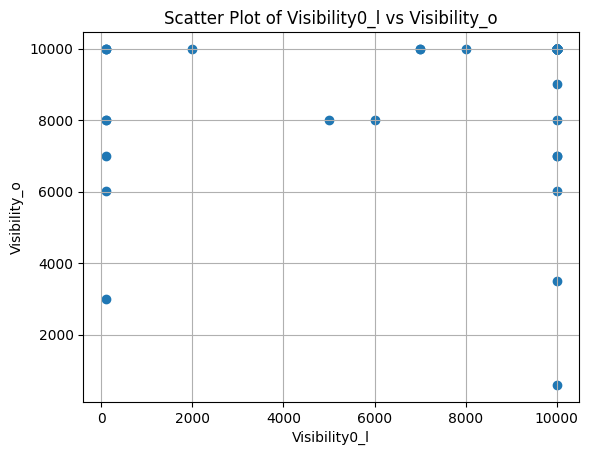

,visibility0,visibility_o,visibility0_l
time,,,
2018-11-23 07:00:00,24042.513672,9994.0,9999
2020-09-18 23:00:00,24042.697266,9994.0,9999
2022-08-30 18:00:00,24231.777344,9994.0,9999
2018-02-07 20:00:00,24091.761719,9994.0,9999
2022-12-24 12:00:00,3436.468506,2993.0,1000
2021-05-20 00:00:00,24135.000000,9994.0,9999
2022-04-03 18:00:00,24052.779297,9994.0,9999
2020-06-27 03:00:00,24037.794922,4007.0,9999
2018-07-11 19:00:00,24035.412109,9994.0,9999


visibility0_l
9999    36273
100      4220
4000      397
3000      394
2000      392
6000      364
5000      354
7000      344
8000      322
1000      181
9000      169
Name: count, dtype: int64

In [3]:
#@title visibility0 vs visibility obs

def custom_round(value):
    if value > 9001:
        return 9999
    elif value < 1000:
        return 100
    else:
        return round(value / 1000) * 1000

df_vis = pd.concat([df_all["visibility0"],station_raw['visibility_o']],axis=1).dropna()
display(df_vis.corr())

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_vis['visibility0_l'] = ((a * df_vis['visibility0'] + b).round().astype(int)).apply(custom_round)

display(df_vis.describe())
df_vis_s = df_vis.sample(100)
plt.scatter(df_vis_s['visibility0_l'], df_vis_s['visibility_o'])
plt.xlabel('Visibility0_l')
plt.ylabel('Visibility_o')
plt.title('Scatter Plot of Visibility0_l vs Visibility_o')
plt.grid(True)
plt.show()
display(df_vis.sample(30))
display(df_vis["visibility0_l"].value_counts())

,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.024886,0.090638,-0.124932
cfl0,0.024886,1.000000,0.321142,-0.351542
cfm0,0.090638,0.321142,1.000000,-0.027278
visibility_o,-0.124932,-0.351542,-0.027278,1.000000


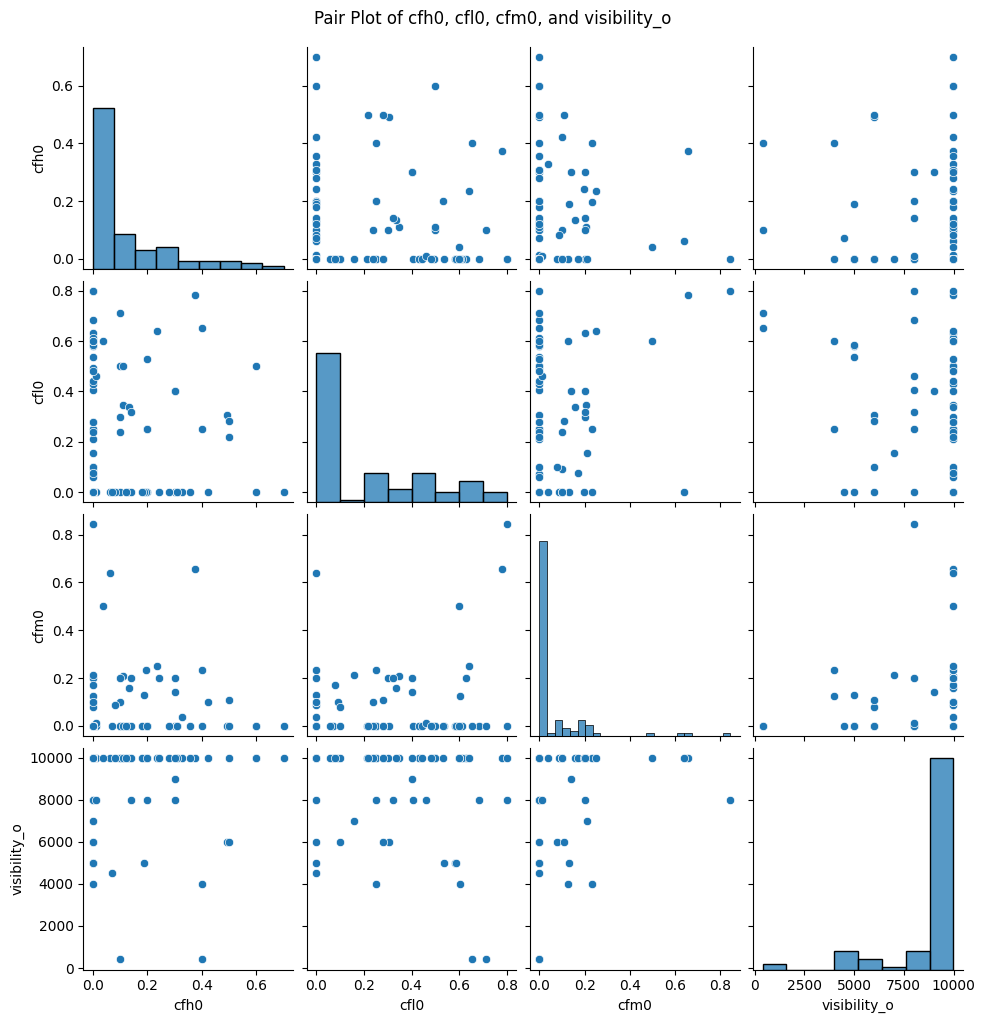

In [4]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


In [5]:
def transform_value(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

df_all["cfl0"] = round(df_all["cfl0"],1)
df_all['cfl0_l'] = df_all['cfl0'].apply(transform_value)
df_all[["cfl0","cfl0_l"]]

,cfl0,cfl0_l
time,,
2018-01-02 00:00:00,0.7,CL7
2018-01-02 01:00:00,0.8,CL8
2018-01-02 02:00:00,0.8,CL8
2018-01-02 03:00:00,0.8,CL8
2018-01-02 04:00:00,0.8,CL8
...,...,...
2023-01-01 19:00:00,0.4,CL4
2023-01-01 20:00:00,0.5,CL5
2023-01-01 21:00:00,0.5,CL5


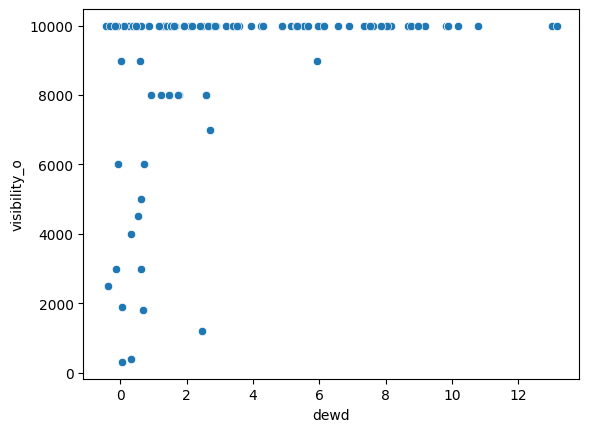

In [6]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");

In [7]:
vis.describe()

,dewd,visibility_o
count,43410.000000,43410.000000
mean,3.090503,8846.994978
std,3.138396,2457.771545
min,-0.499939,48.000000
25%,0.601608,9994.000000
50%,1.988129,9994.000000
75%,4.825790,9994.000000
max,15.975739,9994.000000


In [ ]:
def get_nth_word(text, n):
    # Split the text into words
    words = text.split()
    # Check if the index n is valid
    if n <= 0 or n > len(words):
        return "Invalid index"
    # Get the nth word (indexing starts from 1)
    return words[n - 1]


result["wind_metar"] = [get_nth_word(text, 7) for text in result.fusion]
result["wind_metar"] = result["wind_metar"].astype(str)
result["wind_metar"].value_counts()

wind_metar
VRB02KT       2925
VRB01KT       1894
00000KT       1653
VRB03KT        415
VRB04KT        268
              ... 
25008G19KT       1
03017G28KT       1
04018G30KT       1
05015G27KT       1
21022G38KT       1
Name: count, Length: 1592, dtype: int64

In [ ]:
pd.options.display.max_rows = 999
win = pd.concat([result["wind_metar"],df_all],axis=1).dropna()
win["g"] = ["y" if 'G' in t else "n" for t in win.wind_metar]
win["g"].value_counts(normalize=True)

g
n    0.934904
y    0.065096
Name: proportion, dtype: float64

In [ ]:
win["dif_int"] = win["wind_gust0"]-win["mod0"]
win[win.g=="y"][["mod0","wind_gust0","wind_metar"]].sample(100)

,mod0,wind_gust0,wind_metar
time,,,
2019-11-22 12:00:00,12.261683,18.938030,26009G23KT
2022-12-18 21:00:00,14.252416,22.831747,20021G32KT
2020-07-14 19:00:00,8.070247,12.072361,02015G25KT
2021-01-24 12:00:00,8.522390,13.431847,26011G21KT
2020-11-15 09:00:00,10.541652,16.055607,24015G27KT
2021-01-21 11:00:00,12.389274,18.031359,26015G28KT
2020-11-14 21:00:00,10.162958,15.509943,23012G22KT
2019-11-14 17:00:00,13.744637,20.521610,33013G23KT
2021-10-02 11:00:00,8.936397,16.080908,24013G27KT


In [ ]:
win[win.g=="y"]["wind_gust0"].describe()

count    2708.000000
mean       15.374798
std         4.341556
min         0.360282
25%        12.522136
50%        15.357202
75%        18.211459
max        29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win[win.wind_gust0>11]["g"].value_counts()

g
n    5254
y    2299
Name: count, dtype: int64

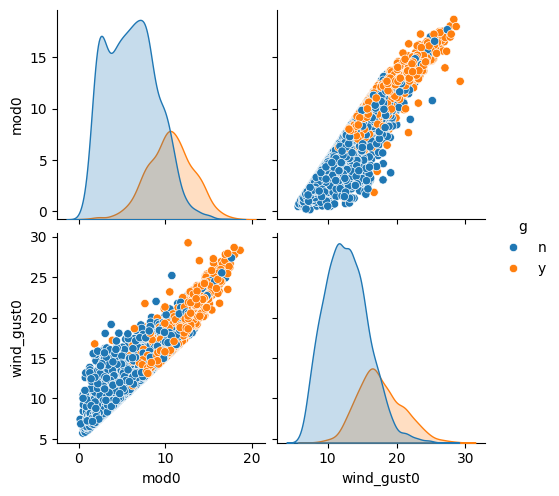

In [ ]:
sns.pairplot(win[win.dif_int>5][["mod0","wind_gust0","g"]],  hue='g',);

In [ ]:
win["wind_gust0"].describe()

count    41600.000000
mean         7.160643
std          4.428968
min          0.023710
25%          3.834732
50%          6.231800
75%          9.638942
max         29.232828
Name: wind_gust0, dtype: float64

In [ ]:
win["dif_int"].describe()

count    41600.000000
mean         2.508166
std          2.341852
min         -2.447657
25%          0.790846
50%          1.655715
75%          3.916108
max         16.575441
Name: dif_int, dtype: float64